In [1]:
import json 
import pathlib
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
from dataflow.core.lispress import parse_lispress, render_compact

In [2]:
def read_jsonl(path):
    with open(path, "r") as f:
        lines = f.readlines()
    return [json.loads(line) for line in lines]

def read_tgt(path):
    with open(path) as f1:
        return [line.strip() for line in f1.readlines()]

In [3]:


def get_data_from_file(path, do_print=False):
    tgt_path = "/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.tgt"
    gold_tgts = read_tgt(tgt_path)
    pred_data = read_jsonl(path)

    correct = 0
    total = 0

    total_rewritten = 0
    total_chosen = 0
    total_uncertain = 0
    total_tokens = 0
    skipped = 0
    for gold_tgt, pred in zip(gold_tgts, pred_data):
        pred_lispress = render_compact(parse_lispress(pred['tgt_str']))
        gold_lispress = render_compact(parse_lispress(gold_tgt))

        if pred_lispress == gold_lispress:
            correct += 1
        total += 1
        try:
            n_uncertain = np.sum(pred['low_conf_tokens'])
            n_chosen = np.sum(pred['ann_chose_from_top_k'])
            n_rewritten = np.sum(pred['ann_manually_inserted'])
            n_tokens_predicted = np.sum(pred['tokens_predicted'])
            total_rewritten += n_rewritten
            total_chosen += n_chosen
            total_uncertain += n_uncertain
            total_tokens += n_tokens_predicted
        except KeyError:
            skipped+=1
            # print(pred)


    em = correct / total
    total_tokens = int(total_tokens)
    total_low_confidence = int(total_uncertain)
    perc_low_confidence = total_low_confidence / total_tokens
    total_chosen = int(total_chosen)
    perc_chosen = total_chosen / total_low_confidence 
    total_rewritten = int(total_rewritten)
    perc_rewritten = total_rewritten / total_low_confidence
    if do_print:
        print(f"Exact match: {correct}/{total} = {correct/total*100:.2f}")
        print(f"total tokens: {int(total_tokens)}")
        print(f"total low confidence: {int(total_uncertain)}: {total_uncertain/total_tokens*100:.2f}% of total tokens")
        print(f"total chosen from top k: {int(total_chosen)}: {total_chosen/total_uncertain*100:.2f}% of uncertain tokens")
        print(f"total manually rewritten: {int(total_rewritten)}: {total_rewritten/total_uncertain*100:.2f}% of uncertain tokens")

    return {"em": em,
            "total_tokens": total_tokens,
            "total_low_confidence": total_low_confidence,
            "perc_low_confidence": perc_low_confidence,
            "total_chosen": total_chosen,
            "perc_chosen": perc_chosen,
            "total_rewritten": total_rewritten,
            "perc_rewritten": perc_rewritten,}

In [4]:
df_to_plot = []
root_dir  = pathlib.Path("/brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data/translate_output_hitl/")

for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    path = root_dir / f"dev_all_{thresh}.tgt"
    try:
        data = get_data_from_file(path)
    except FileNotFoundError:
        print(f"Missing: {path}")
        continue
    data['threshold'] = thresh
    df_to_plot.append(data) 

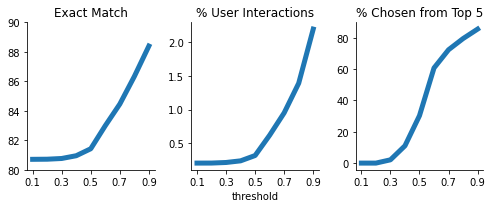

In [5]:
df = pd.DataFrame(df_to_plot)

df['em'] *= 100
df['perc_chosen'] *= 100
df['perc_low_confidence'] *= 100
fig, ax = plt.subplots(1, 3, figsize=(7, 3), sharex=True)
sns.lineplot(data=df, x="threshold", y="em", ax = ax[0], linewidth=5)
ax[0].set_xticks([0.1,  0.3, 0.5,  0.7, 0.9])
ax[0].set_title("Exact Match")
ax[0].set_ylabel("")
ax[0].set_ylim(80, 90)
ax[0].set_xlabel("")

sns.lineplot(data=df, x="threshold", y="perc_low_confidence", ax = ax[1], linewidth=5)
ax[1].set_ylabel("")
ax[1].set_title("% User Interactions")

sns.lineplot(data=df, x="threshold", y="perc_chosen", ax = ax[2], linewidth=5)
ax[2].set_ylabel("")
ax[2].set_title("% Chosen from Top 5")
ax[2].set_xlabel("")
sns.despine() 

plt.tight_layout()
plt.savefig("/home/estengel/papers/did-you-mean-2022/figures/sim_hitl_results.pdf") 